In [5]:
import numpy as np
import matplotlib.pyplot as plt
from poles_roots.aaa import AAA
from poles_roots.delves_lyness import delves_lyness
from poles_roots.kravanja_van_barel import kravanja_van_barel
from poles_roots._utils import convert_cart_to_complex, compute_incenter
from cxroots import Rectangle
from tqdm import tqdm
plt.style.use(['science','ieee'])
plt.rcParams['font.size'] = 13

- Order
- Number
- Distance from edge

In [6]:
side_length = 1

points = np.array([[0,0], [side_length, 0], [side_length, side_length], [0, side_length]])

def linspace_in_square(num, side_length):
    tmp = np.linspace(0, side_length, num=round(num**0.5))
    [xx, yy] = np.meshgrid(tmp, tmp)
    return xx.ravel() + yy.ravel()*1j

In [7]:
delves_lyness_error = []
delves_lyness_function_count = []
kravanja_van_barel_error = []
kravanja_van_barel_function_count = []
aaa_error = []
aaa_function_count = []
orders = [1, 2, 4, 8]
function_eval_steps = 30

zero = 0.5 + 0.5j

c = Rectangle((0,1),(0,1))

    
for order in orders:
    delves_lyness_error_tmp = []
    delves_lyness_function_count_tmp = []
    kravanja_van_barel_error_tmp = []
    kravanja_van_barel_function_count_tmp = []
    aaa_error_tmp = []
    aaa_function_count_tmp = []
    
    # integration based methods
    for tol in np.logspace(0, -13, num=function_eval_steps):
        count = 0
        def f(z):
            global count
            count += 1
            return (z-zero)**order
        def f_prime(z):
            return order*(z-zero)**(order-1)
        res = delves_lyness(f, f_prime, convert_cart_to_complex(points), quad_kwargs={"epsabs":tol, "epsrel": tol})
        delves_lyness_error_tmp.append(np.min(np.abs(res - zero)))
        delves_lyness_function_count_tmp.append(count)
        count = 0
        res = kravanja_van_barel(f, f_prime, convert_cart_to_complex(points), quad_kwargs={"epsabs":tol, "epsrel": tol})[0]
        kravanja_van_barel_error_tmp.append(np.min(np.abs(res - zero)))
        kravanja_van_barel_function_count_tmp.append(count)
    
    # AAA
    for n in np.logspace(1, 3, num=function_eval_steps):
        z = linspace_in_square(n, side_length)
        aaa_function_count_tmp.append(z.size)
        r = AAA(f_prime(z)/f(z), z)
        aaa_error_tmp.append(np.min(np.abs(zero - r.poles)))
    delves_lyness_error.append(delves_lyness_error_tmp)
    delves_lyness_function_count.append(delves_lyness_function_count_tmp)
    kravanja_van_barel_error.append(kravanja_van_barel_error_tmp)
    kravanja_van_barel_function_count.append(kravanja_van_barel_function_count_tmp)
    aaa_function_count.append(aaa_function_count_tmp)
    aaa_error.append(aaa_error_tmp)

/tmp/ipykernel_2125671/1072818171.py:42: RuntimeWarning: divide by zero encountered in divide
  r = AAA(f_prime(z)/f(z), z)
/tmp/ipykernel_2125671/1072818171.py:42: RuntimeWarning: invalid value encountered in divide
  r = AAA(f_prime(z)/f(z), z)


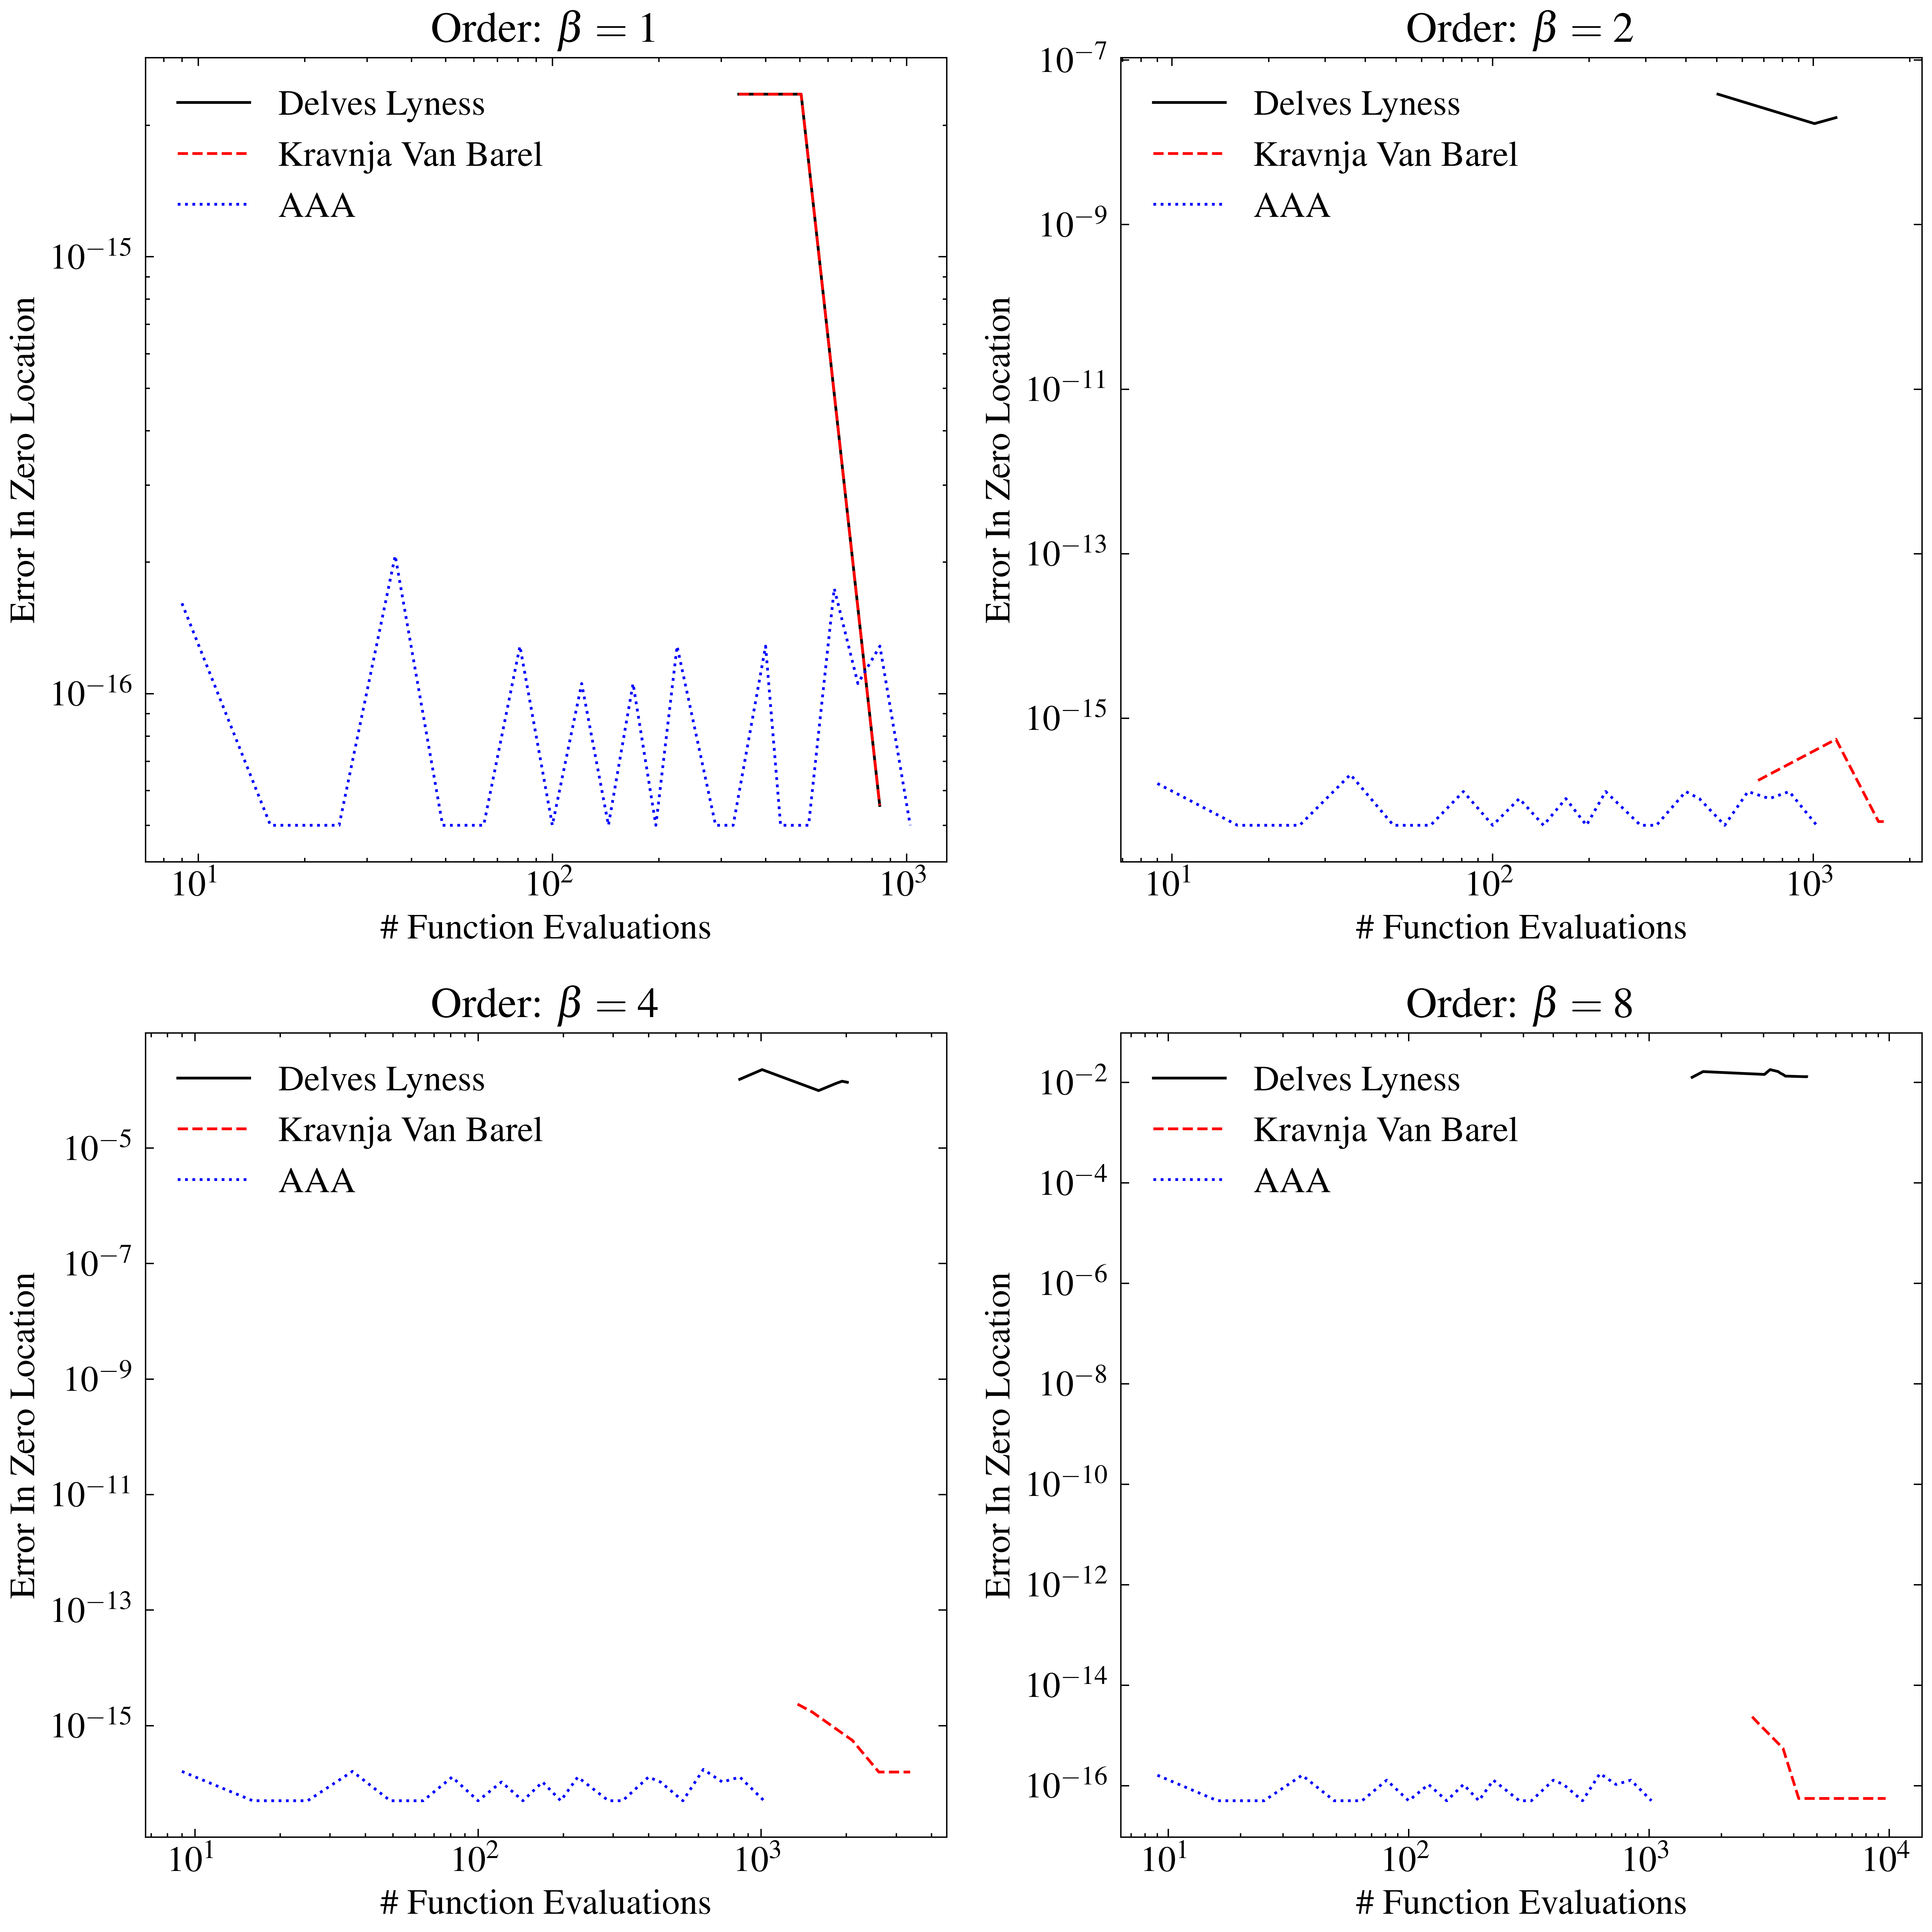

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for i, order in enumerate(orders):
    ax = axs.ravel()[i]
    ax.loglog(delves_lyness_function_count[i], delves_lyness_error[i], label="Delves Lyness")
    ax.loglog(kravanja_van_barel_function_count[i], kravanja_van_barel_error[i], label="Kravnja Van Barel")
    ax.loglog(aaa_function_count[i], np.asarray(aaa_error[i])+5e-17, label="AAA")
    ax.set_xlabel(r"\# Function Evaluations")
    ax.set_ylabel("Error In Zero Location")
    ax.set_title(rf"Order: $\beta={orders[i]}$")
    ax.legend()
plt.tight_layout()
plt.savefig("figures/method_comparison_order.pdf")

In [9]:
from sympy import symbols
from sympy.utilities.lambdify import lambdify
n_zeros = [2, 4, 8, 16]
zeros_sets = [np.linspace(0.1, 0.9, num=n) + 0.5j for n in n_zeros]
fs = []
f_primes = []

z_ = symbols("z")

for zeros in zeros_sets:
    f = z_ - zeros[0]
    for zero in zeros[1:]:
        f *= z_ - zero
    fs.append(lambdify(z_, f))
    f_primes.append(lambdify(z_, f.diff(z_)))

In [13]:
delves_lyness_error = []
delves_lyness_function_count = []
kravanja_van_barel_error = []
kravanja_van_barel_function_count = []
aaa_error = []
aaa_function_count = []
function_eval_steps = 10

    
for i in range(4):
    delves_lyness_error_tmp = []
    delves_lyness_function_count_tmp = []
    kravanja_van_barel_error_tmp = []
    kravanja_van_barel_function_count_tmp = []
    aaa_error_tmp = []
    aaa_function_count_tmp = []
    
    # integration based methods
    for tol in np.logspace(0, -13, num=function_eval_steps):
        count = 0
        def f(z):
            global count
            count += 1
            return fs[i](z)
        def f_prime(z):
            return f_primes[i](z)
        res = delves_lyness(f, f_prime, convert_cart_to_complex(points), quad_kwargs={"epsabs":tol, "epsrel": tol})
        error = np.min(np.abs(np.subtract.outer(res, zeros_sets[i])), axis=0)
        delves_lyness_error_tmp.append(np.median(error))
        delves_lyness_function_count_tmp.append(count)
        count = 0
        res = kravanja_van_barel(f, f_prime, convert_cart_to_complex(points), quad_kwargs={"epsabs":tol, "epsrel": tol})[0]
        error = np.min(np.abs(np.subtract.outer(res, zeros_sets[i])), axis=0)
        kravanja_van_barel_error_tmp.append(np.median(error))
        kravanja_van_barel_function_count_tmp.append(count)
    
    # AAA
    for n in np.logspace(1, 3, num=function_eval_steps):
        z = linspace_in_square(n, side_length)
        aaa_function_count_tmp.append(z.size)
        r = AAA(f_prime(z)/f(z), z)
        error = np.min(np.abs(np.subtract.outer(r.poles, zeros_sets[i])), axis=0)
        aaa_error_tmp.append(np.median(error))
    delves_lyness_error.append(delves_lyness_error_tmp)
    delves_lyness_function_count.append(delves_lyness_function_count_tmp)
    kravanja_van_barel_error.append(kravanja_van_barel_error_tmp)
    kravanja_van_barel_function_count.append(kravanja_van_barel_function_count_tmp)
    aaa_function_count.append(aaa_function_count_tmp)
    aaa_error.append(aaa_error_tmp)

/tmp/ipykernel_2125671/1536503227.py:41: RuntimeWarning: divide by zero encountered in divide
  r = AAA(f_prime(z)/f(z), z)
/tmp/ipykernel_2125671/1536503227.py:41: RuntimeWarning: invalid value encountered in divide
  r = AAA(f_prime(z)/f(z), z)


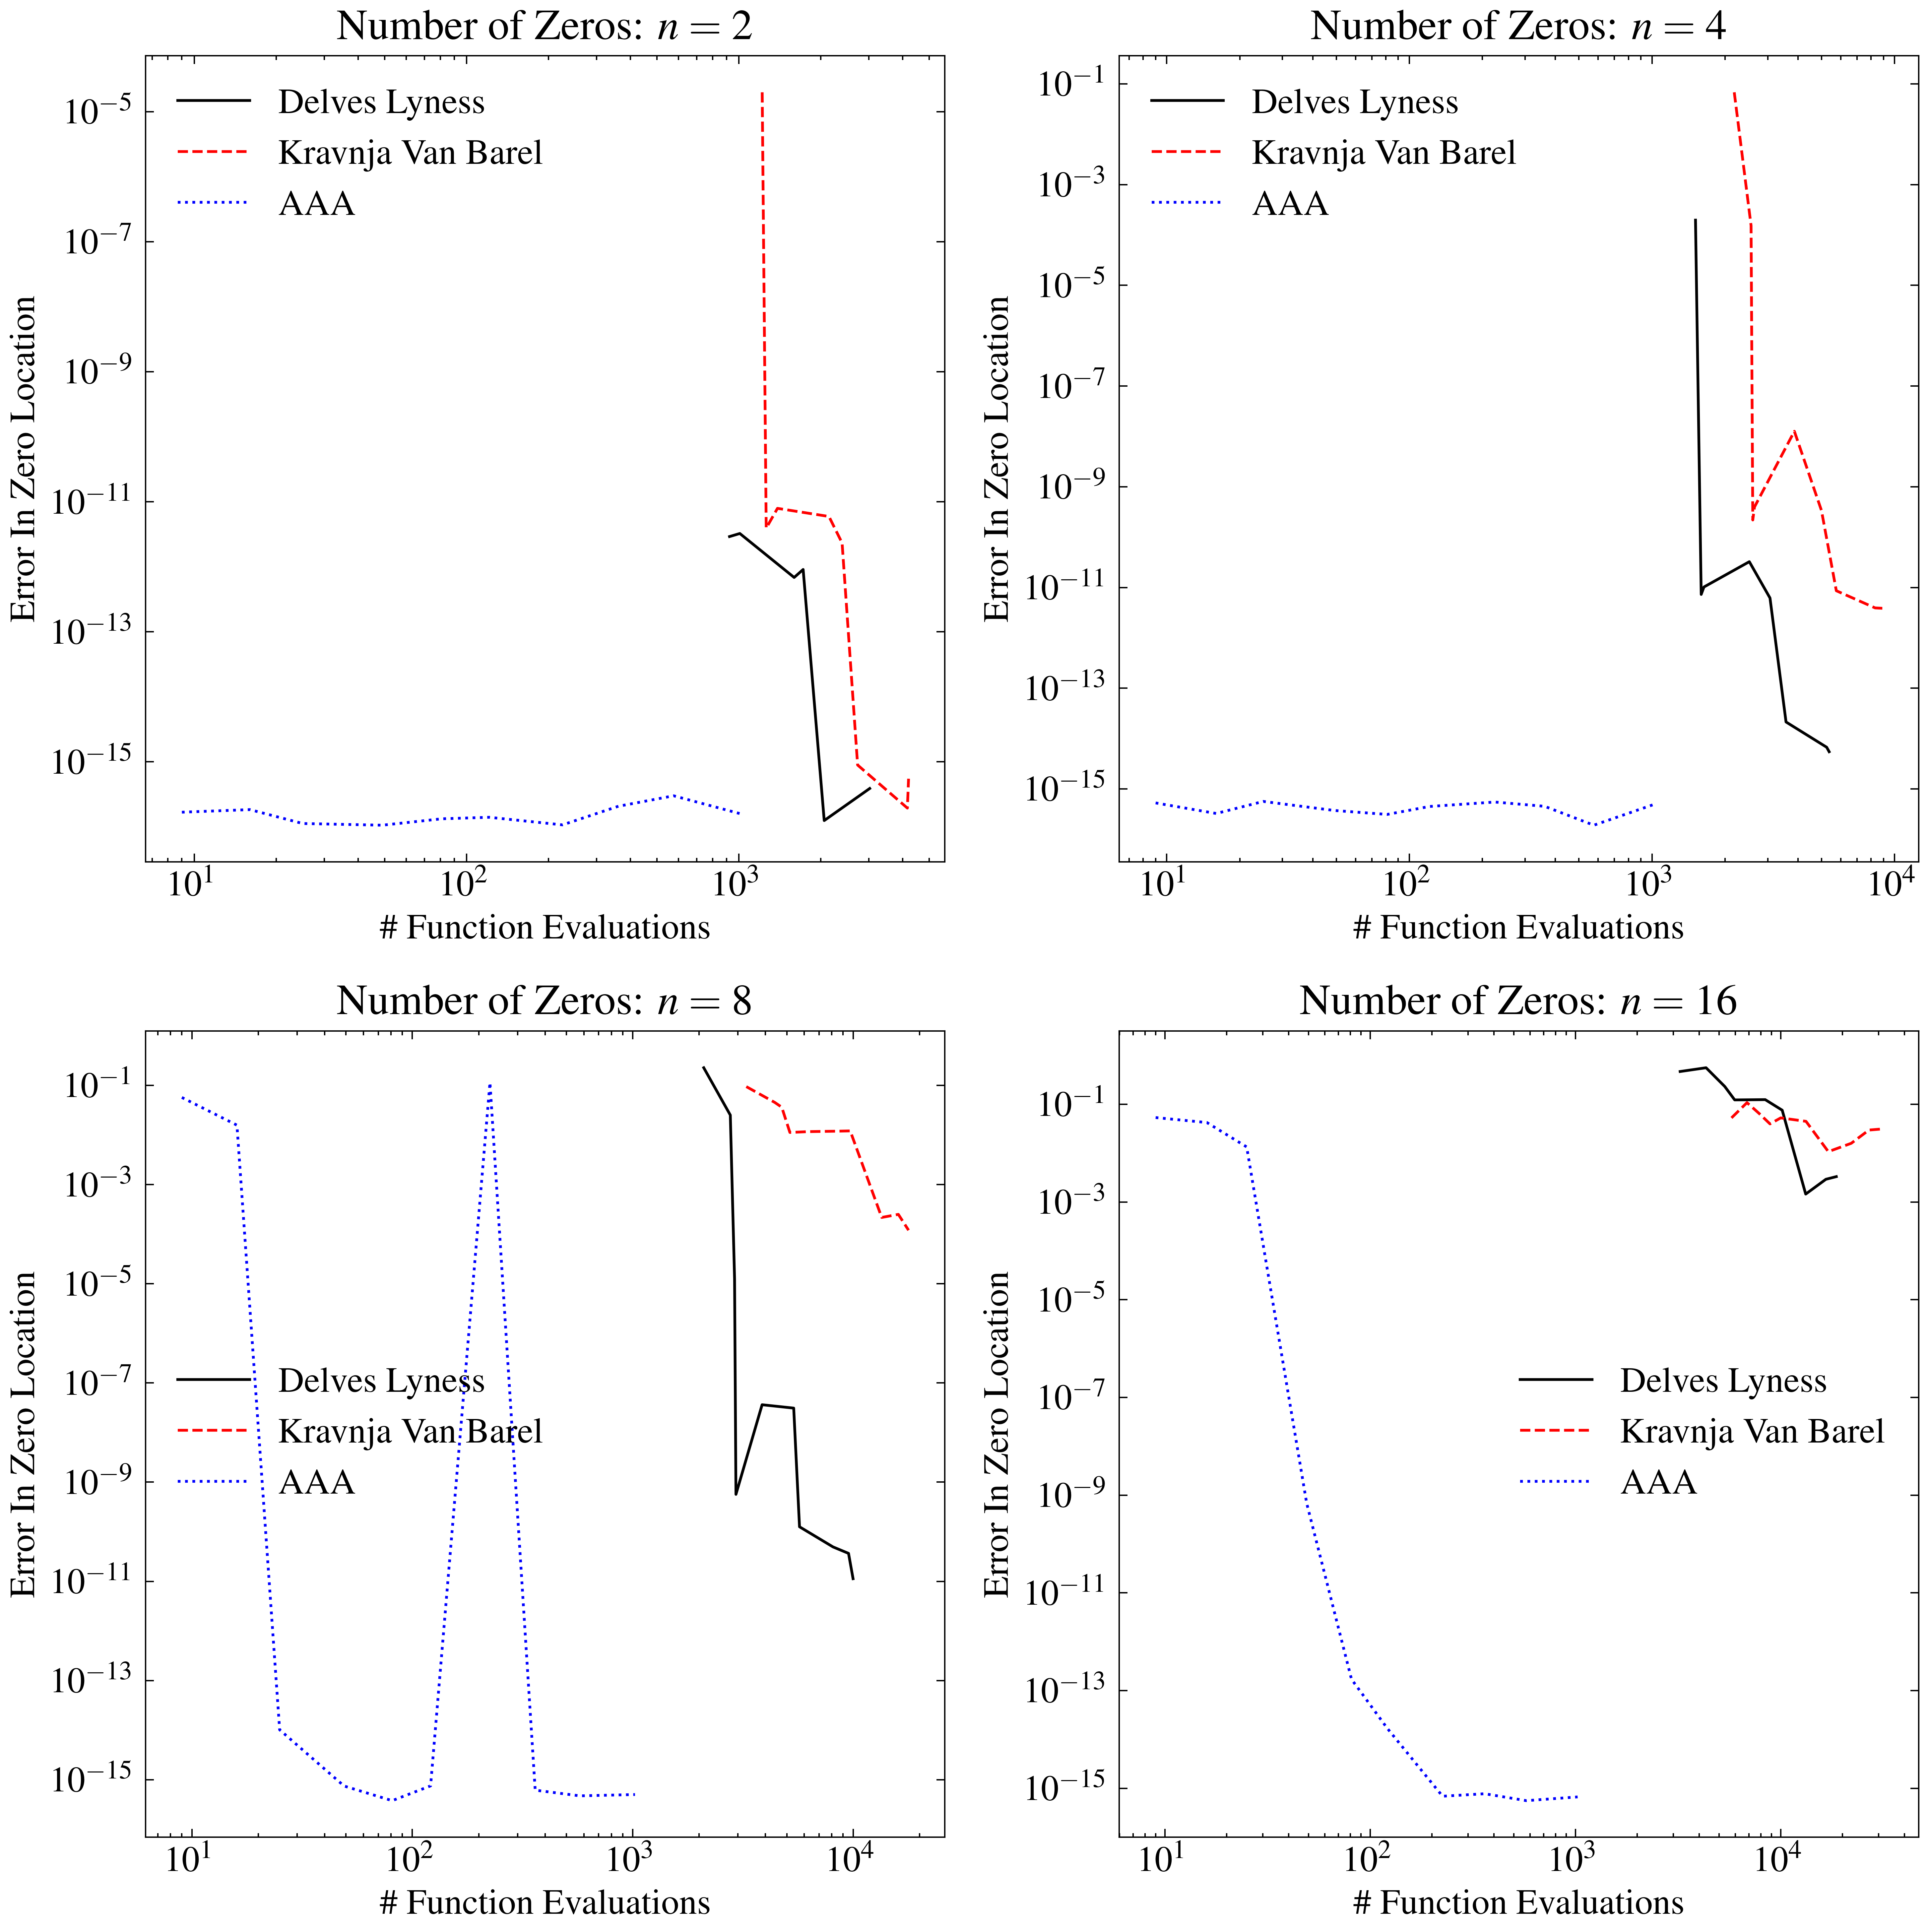

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for i, order in enumerate(orders):
    ax = axs.ravel()[i]
    ax.loglog(delves_lyness_function_count[i], delves_lyness_error[i], label="Delves Lyness")
    ax.loglog(kravanja_van_barel_function_count[i], kravanja_van_barel_error[i], label="Kravnja Van Barel")
    ax.loglog(aaa_function_count[i], np.asarray(aaa_error[i])+5e-17, label="AAA")
    ax.set_xlabel(r"\# Function Evaluations")
    ax.set_ylabel("Error In Zero Location")
    ax.set_title(rf"Number of Zeros: $n={n_zeros[i]}$")
    ax.legend()
plt.tight_layout()
plt.savefig("figures/method_comparison_number_zeros.pdf")